<a href="https://colab.research.google.com/github/daspillegh/DavidPilhofer_TFE21-2_DeepDive/blob/main/DavidPilhoferDeepDiveAbgabe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modell für die Hausarbeit in DeepLearning

In [1]:
# Importing all the good stuff!
# Check if Repo is working
from IPython.display import display, clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model


11490434/11490434 [==============================] - 0s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


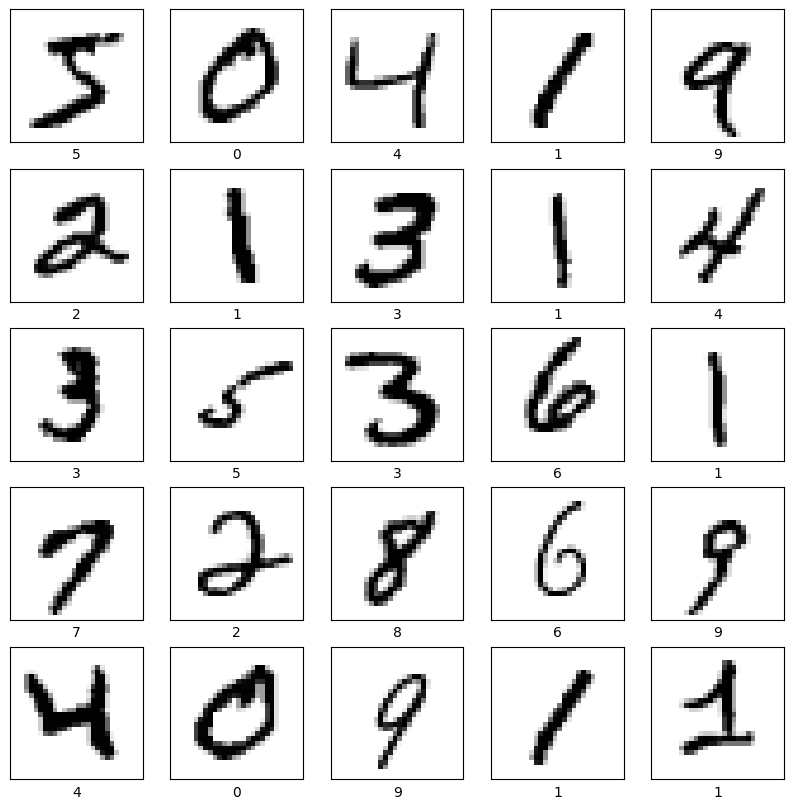

In [2]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

augmented_x_train: (30000, 28, 28)
augmented_y_train: (30000,)
x_test (10000, 28, 28)
y_test (10000,)

 Plot of the first 25 samples in the MNIST training set


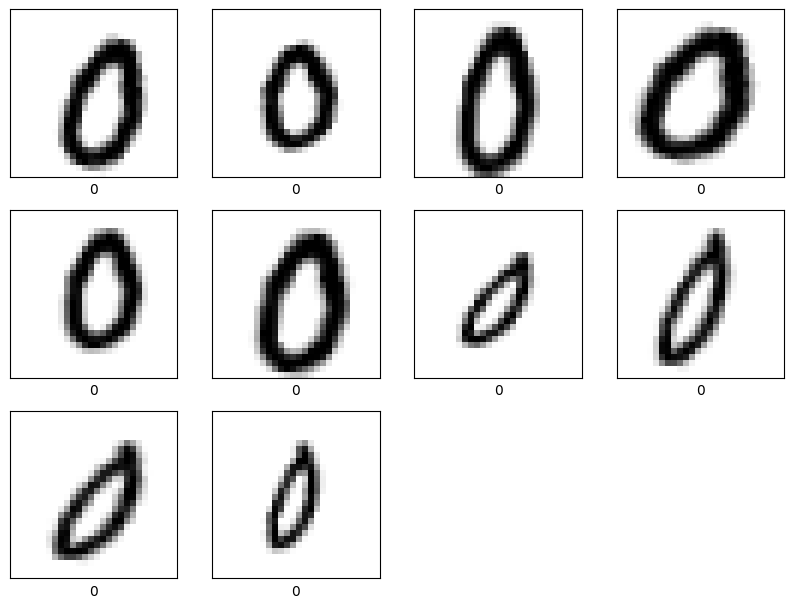

In [41]:
# Versuch die Anzahl der Label zu reduzieren und die Daten zu augmentieren um diese Daten zu erweitern

# Laden des MNIST-Datensatzes
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Funktion zum Reduzieren der Anzahl der Label pro Klasse
def reduce_and_augment_data(x, y, num_samples_per_class, augmentation_factor=6):
    reduced_x = []
    reduced_y = []

    unique_labels = np.unique(y)

    for label in unique_labels:
        indices = np.where(y == label)[0]
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=False)

        # Reduziere die Anzahl der Label pro Klasse
        reduced_x.extend(x[selected_indices])
        reduced_y.extend(y[selected_indices])


    # Augmentiere die reduzierten Daten
    augmented_x, augmented_y = augment_data(reduced_x, reduced_y, augmentation_factor)

    return np.array(augmented_x), np.array(augmented_y)

# Funktion zum Augmentieren der Daten
def augment_data(x, y, augmentation_factor):
    augmented_data = []
    augmented_labels = []

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.2,
        fill_mode='constant',
        cval=0,
        vertical_flip=False,
        horizontal_flip=False,
    )

    for img, label in zip(x, y):
        img = img.reshape((1,) + img.shape + (1,))
        label = np.array([label])

        i = 0
        for batch, labels in datagen.flow(img, label, batch_size=1):
            augmented_data.append(batch[0].reshape(img.shape[1: -1]))
            augmented_labels.append(labels[0])
            i += 1
            if i >= augmentation_factor:
                break

    return augmented_data, augmented_labels

# Anzahl der Label pro Klasse, die Sie behalten möchten
num_samples_per_class = 500

# Reduziere die Anzahl der Label pro Klasse und augmentiere die Daten
augmented_x_train, augmented_y_train = reduce_and_augment_data(x_train, y_train, num_samples_per_class)

# Überprüfen Sie die Form der augmentierten und reduzierten Trainingsdaten
print('augmented_x_train:', np.array(augmented_x_train).shape)
print('augmented_y_train:', np.array(augmented_y_train).shape)
print('x_test',np.array(x_test).shape)
print('y_test',np.array(y_test).shape)

# Plotting data samples
print('\n Plot of the first 10 samples in the MNIST training set')
numbers_to_display = 10
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_x_train[i], cmap=plt.cm.binary)
    plt.xlabel(augmented_y_train[i])
plt.show()


y_train = augmented_y_train

x_train_normalized = augmented_x_train /255
x_test_normalized = x_test/255

x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)


In [132]:
#plt.imshow(x_train[99][:,:,0])
#print(y_train[99])

In [113]:
# In this code cell you define your models architecture

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [115]:
# This Cell plots the summary of your model

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 flatten_18 (Flatten)        (None, 5408)              0         
                                                                 
 dense_36 (Dense)            (None, 64)                346176    
                                                                 
 dense_37 (Dense)            (None, 10)                650       
                                                     

In [116]:
# Define your loss

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], model(x_train[sampleID-1:sampleID]).numpy()).numpy()


tf.Tensor(2.3025851, shape=(), dtype=float32)


2.3004227

In [117]:
# Compile your model

model.compile(optimizer='adam',
              loss= loss_fn ,
              metrics=['accuracy'])

In [118]:
# Define early stopping callback on validation loss
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=False,
)

# Reduce learning rate when validation loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4
)

# Sichern der besten Gewichte nach dem Training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    'dein_modell.h5',
                    monitor="val_accuracy",
                    mode="max",
                    save_best_only=True,
                    verbose=1
)


In [119]:
# Finally train your model

model.fit(
    x_train,
    y_train,
    epochs= 30,
    batch_size= 32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


# Modell speichern
model.save('dein_modell.h5')



Epoch 1/30
925/938 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.8563
Epoch 1: val_accuracy improved from -inf to 0.97250, saving model to dein_modell.h5
938/938 [==============================] - 5s 4ms/step - loss: 0.4630 - accuracy: 0.8573 - val_loss: 0.0885 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 2/30
925/938 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.9419
Epoch 2: val_accuracy improved from 0.97250 to 0.97540, saving model to dein_modell.h5
938/938 [==============================] - 4s 4ms/step - loss: 0.1850 - accuracy: 0.9418 - val_loss: 0.0764 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 3/30
930/938 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9573
Epoch 3: val_accuracy improved from 0.97540 to 0.97670, saving model to dein_modell.h5
938/938 [==============================] - 4s 4ms/step - loss: 0.1352 - accuracy: 0.9573 - val_loss: 0.0739 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 4/30
936/938 [==

313/313 [==============================] - 1s 2ms/step


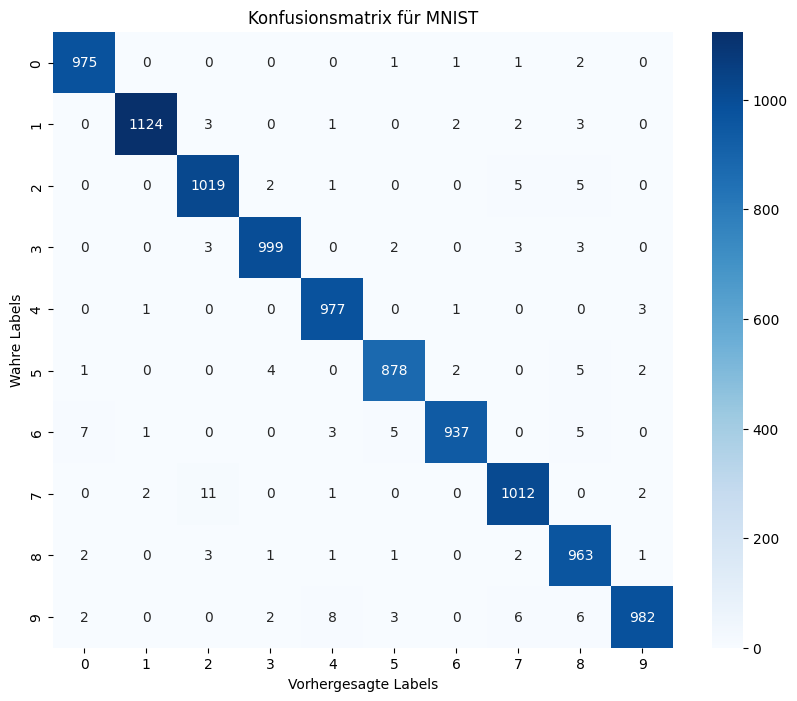

In [92]:
model = load_model('dein_modell.h5')

predictions = model.predict(x_test)
predicted_labels = tf.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_labels)

# Konfusionsmatrix visualisieren
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Konfusionsmatrix für MNIST')
plt.show()
